# Introduction

This code aims to evaluate stock market predictions using random forest algorithm. Here we try to replicate Khaidem et al paper with a few differences. Random forests differs from many other machine learning methods because it does not strictly need parameter tuning. Introduced by Breiman (2001), it is an aggregation of decisions trees. First, a bootstrapped sample is taken from the training set. Then, a number of random features are taken to form a decision tree. At last, each tree is trained and grow to the fullest possible extention without pruning. Those three steps are repeated n times in order to form random decision trees. Each tree gives a classification and the classification that has the higher number of votes is chosen. For the number of trees in the random forests. Since we will not be tuning the model’s parameters, we are only going to split the data to train and test set (no validation set). For the scores, Here, we used the accuracy score and the f1 score. 

$$F1 =2\frac { precision\times recall }{ precision+recall }$$  
$$precision=\frac { tp }{ tp+fp }$$
$$recall=\frac { tp }{ tp+fn }$$

where tp is the number of positive instances classifier as positive, fp is the number of negative instances classified as positive and fn is the number of positive instances classified as negative. Because of the randomness of the model, each train set is trained 5 times and the average of the scores on the test set is the final score. All of the calculation were done by python’s scikit-learn library.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np
from talib.abstract import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import cufflinks as cf

# Data
Data for all the stocks were collected from Yahoo finances using pandas datareader. The time series goes from  May 5th, 1998 to May 4th, 2015 and we predicted the movement from 1 to 20 days in the future.

In [2]:
start = datetime.datetime(1998, 1, 1)
end = datetime.datetime(2016, 6, 30)
top_500 = ['AAPL', 'MSFT', 'XOM', 'JNJ', 'GE', 'BRK-B', 'T', 'VZ']

In [3]:
f = web.DataReader(top_500, 'yahoo',start,end)
cleanData = f.ix[0:4655,'Adj Close']
stock_data = pd.DataFrame(cleanData)
stock_data

Attributes  Adj Close                                               \
Symbols          AAPL       MSFT        XOM         JNJ         GE   
Date                                                                 
1998-01-02   0.504969  10.545034  15.760149   18.234844  11.615955   
1998-01-05   0.493316  10.484719  15.585035   18.217323  11.821985   
1998-01-06   0.588483  10.545034  15.027866   17.937063  11.665018   
1998-01-07   0.543813  10.419375  15.505444   18.112230  11.763124   
1998-01-08   0.565177  10.494770  15.171139   18.322433  11.655203   
...               ...        ...        ...         ...        ...   
2016-06-27  87.002052  45.297375  77.092430  106.120209  25.553814   
2016-06-28  88.467209  46.242058  78.870972  107.649872  26.094175   
2016-06-29  89.232864  47.270897  80.215683  108.651436  26.625816   
2016-06-30  90.367195  47.860149  81.326195  110.445160  27.436356   
2016-07-01  90.641319  47.850803  81.412933  110.436050  27.445074   

Attributes                                        Close             ...  \
Symbols          BRK-B          T         VZ       AAPL       MSFT  ...   
Date                                                                ...   
1998-01-02   30.580000  13.491593  14.616565   0.580357  16.390625  ...   
1998-01-05   31.100000  13.109009  14.174552   0.566964  16.296875  ...   
1998-01-06   31.180000  13.052757  14.516106   0.676339  16.390625  ...   
1998-01-07   31.459999  13.213163  14.499701   0.625000  16.195312  ...   
1998-01-08   31.799999  13.088620  14.294907   0.649554  16.312500  ...   
...                ...        ...        ...        ...        ...  ...   
2016-06-27  138.500000  34.737186  46.805599  92.040001  48.430000  ...   
2016-06-28  140.279999  34.728924  46.874004  93.589996  49.439999  ...   
2016-06-29  142.119995  35.158691  47.079216  94.400002  50.540001  ...   
2016-06-30  144.789993  35.712440  47.746155  95.599998  51.169998  ...   
2016-07-01  143.960007  35.927326  48.079624  95.889999  51.160000  ...   

Attributes       Open                  Volume                          \
Symbols             T         VZ         AAPL        MSFT         XOM   
Date                                                                    
1998-01-02  37.000000  41.593678  179527600.0  39748000.0   5657200.0   
1998-01-05  37.000000  40.638145  162968400.0  80377600.0   8728400.0   
1998-01-06  36.281250  39.682617  453118400.0  67834400.0   9009200.0   
1998-01-07  36.093750  40.272797  260405600.0  61492800.0  11663600.0   
1998-01-08  36.000000  39.795033  193505200.0  77619200.0   6357600.0   
...               ...        ...          ...         ...         ...   
2016-06-27  41.290001  54.060001   45489600.0  50216300.0  14169400.0   
2016-06-28  42.139999  54.759998   40444900.0  38140700.0  13254300.0   
2016-06-29  42.220001  54.820000   36531000.0  31304000.0  13920600.0   
2016-06-30  42.689999  55.270000   35836400.0  28527800.0  14073700.0   
2016-07-01  43.209999  55.849998   26026500.0  21400400.0   9946300.0   

Attributes                                                             
Symbols            JNJ          GE      BRK-B           T          VZ  
Date                                                                   
1998-01-02   4656400.0   9762700.0    65000.0   4363200.0   3931200.0  
1998-01-05   5308200.0  17606700.0   320000.0   5904400.0   3628700.0  
1998-01-06   4971400.0  12856800.0   300000.0   5815800.0   4532400.0  
1998-01-07   3768200.0  10416100.0   175000.0   4038800.0   3831600.0  
1998-01-08   6087800.0  11953300.0   165000.0   3694000.0   4006200.0  
...                ...         ...        ...         ...         ...  
2016-06-27  10877400.0  56201700.0  6328200.0  37455400.0  22570200.0  
2016-06-28  10089600.0  39736800.0  5312300.0  34419000.0  17780600.0  
2016-06-29   8341500.0  37302900.0  4257100.0  23671500.0  18184100.0  
2016-06-30  11559900.0  56695000.0  5196400.0  31913400.0  22143300.0  
2016-07-0

## Data visualization
Here we can see the time series plot for all the 8 companies stocks movements.

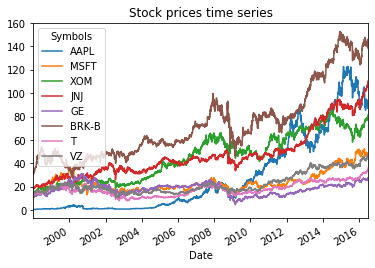

In [5]:
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline
# Plot the close prices
stock_data.plot()
plt.title('Stock prices time series')
plt.show()


In [6]:
stocks = {}
for i in top_500:
    stocks[i] = web.DataReader(i, 'yahoo',start,end)

In [7]:
for i,j in enumerate(stocks):
    stocks[j].columns = [s.lower() for s in stocks[j].columns]
    stocks[j].volume = stocks[j].volume.apply(lambda x: float(x))

## Technical indicators
The technical indicators were calculated with default parameters settings using TA-Lib python package. They are summarized in the table below where Pt is the closing price at the day t, Ht is the high price at day t, Lt is the low price at day t, HHn is the highest high during the last n days, LLt is the lowest low during the last n days, and EMA(n) is the exponential moving average. 

![alt text](http://ahmedas91.github.io/images/rf_table.png "Technical indicators")

In [8]:
def get_indicators(stocks, period):
    stocks_indicators = {}
    for i in stocks:
        features = pd.DataFrame(SMA(stocks[i], timeperiod=5))
        features.columns = ['sma_5']
        features['sma_10'] = pd.DataFrame(SMA(stocks[i], timeperiod=10))
        features['mom_10'] = pd.DataFrame(MOM(stocks[i],10))
        features['wma_10'] = pd.DataFrame(WMA(stocks[i],10))
        features['wma_5'] = pd.DataFrame(WMA(stocks[i],5))
        features = pd.concat([features,STOCHF(stocks[i], 
                                          fastk_period=14, 
                                          fastd_period=3)],
                             axis=1)
        features['macd'] = pd.DataFrame(MACD(stocks[i], fastperiod=12, slowperiod=26)['macd'])
        features['rsi'] = pd.DataFrame(RSI(stocks[i], timeperiod=14))
        features['willr'] = pd.DataFrame(WILLR(stocks[i], timeperiod=14))
        features['cci'] = pd.DataFrame(CCI(stocks[i], timeperiod=14))
        features['adosc'] = pd.DataFrame(ADOSC(stocks[i], fastperiod=3, slowperiod=10))
        features['pct_change'] = ROC(stocks[i], timeperiod=period)
        features['pct_change'] = features['pct_change'].shift(-period)
        features['pct_change'] = features['pct_change'].apply(lambda x: '1' if x > 0 else '0' if x <= 0 else np.nan)
        features = features.dropna()
        features = features.iloc[np.where(features.index=='1998-5-5')[0][0]:np.where(features.index=='2015-5-5')[0][0]]
        stocks_indicators[i] = features
    return stocks_indicators

In [9]:
stocks_indicators = get_indicators(stocks, 1)

In [10]:
stocks_indicators['AAPL'].head()

,sma_5,sma_10,mom_10,wma_10,wma_5,fastk,fastd,macd,rsi,willr,cci,adosc,pct_change
Date,,,,,,,,,,,,,
1998-05-05,1.008036,0.996205,0.024554,1.005479,1.024851,94.827559,76.670918,0.024356,65.507379,-5.172441,149.900739,1.206611e+07,1
1998-05-06,1.031696,1.006250,0.100446,1.021185,1.049702,97.014936,91.725282,0.028952,68.116586,-2.985064,159.423507,7.128966e+07,0
1998-05-07,1.051786,1.015179,0.089286,1.034253,1.065179,90.000000,93.947498,0.031867,67.024571,-10.000000,137.254909,8.170652e+07,1
1998-05-08,1.069196,1.024107,0.089286,1.047321,1.076935,95.714264,94.243067,0.034500,68.125193,-4.285736,116.666692,9.529502e+07,1
1998-05-11,1.082589,1.035491,0.113839,1.062013,1.088839,87.209319,90.974528,0.037594,70.262972,-12.790681,134.908508,6.196259e+07,0


In [11]:
len(stocks_indicators['AAPL'])

4277

### Investigating the data structure
Before proceeding with training the data, we had to check weather the data are balanced. The figure below shows the percentage of positive returns instances for each day and for each stock. Fortunately, the data does not need to be balanced since they are almost evenly split for all the stocks.

In [12]:
def weighs_tabale(stocks, period):
    table = pd.DataFrame()
    for j in stocks:
        weighs_1 = []
        for i in range(1,period+1):
            stocks_indicators = get_indicators(stocks, i)
            weighs_1.append((len(stocks_indicators[j][stocks_indicators[j]['pct_change']=='1'])/\
                            float(len(stocks_indicators[j])))*100)
        table = pd.concat([table, pd.DataFrame(weighs_1)], axis=1)
    table.index = range(1,period+1)
    table.columns = stocks.keys()
    return table

In [13]:
table = weighs_tabale(stocks, 20)
table

,AAPL,MSFT,XOM,JNJ,GE,BRK-B,T,VZ
1,51.905541,49.357026,50.736498,50.479308,48.912789,47.813888,49.941548,49.918167
2,53.238251,50.011690,51.835399,50.876783,50.128595,49.754501,49.918167,50.268880
3,54.570961,50.549451,52.864157,52.419921,50.853402,50.198737,50.385784,50.713117
4,55.552958,50.853402,53.986439,53.565583,49.427169,50.292261,50.526070,51.882160
5,56.418050,51.274258,53.916296,52.653729,49.894786,50.830021,49.941548,51.391162
6,56.792144,52.349778,53.986439,53.214870,50.128595,51.812018,50.455927,51.040449
7,56.441431,52.536825,54.056582,53.565583,50.292261,52.045827,49.731120,49.988310
8,57.820903,52.910919,54.103343,53.776011,50.619593,51.765256,50.011690,50.292261
9,57.984569,52.443301,54.243629,54.337152,50.502689,52.630348,50.479308,50.222118
10,57.867664,53.401917,54.056582,54.945055,50.549451,52.981061,50.642974,50.198737


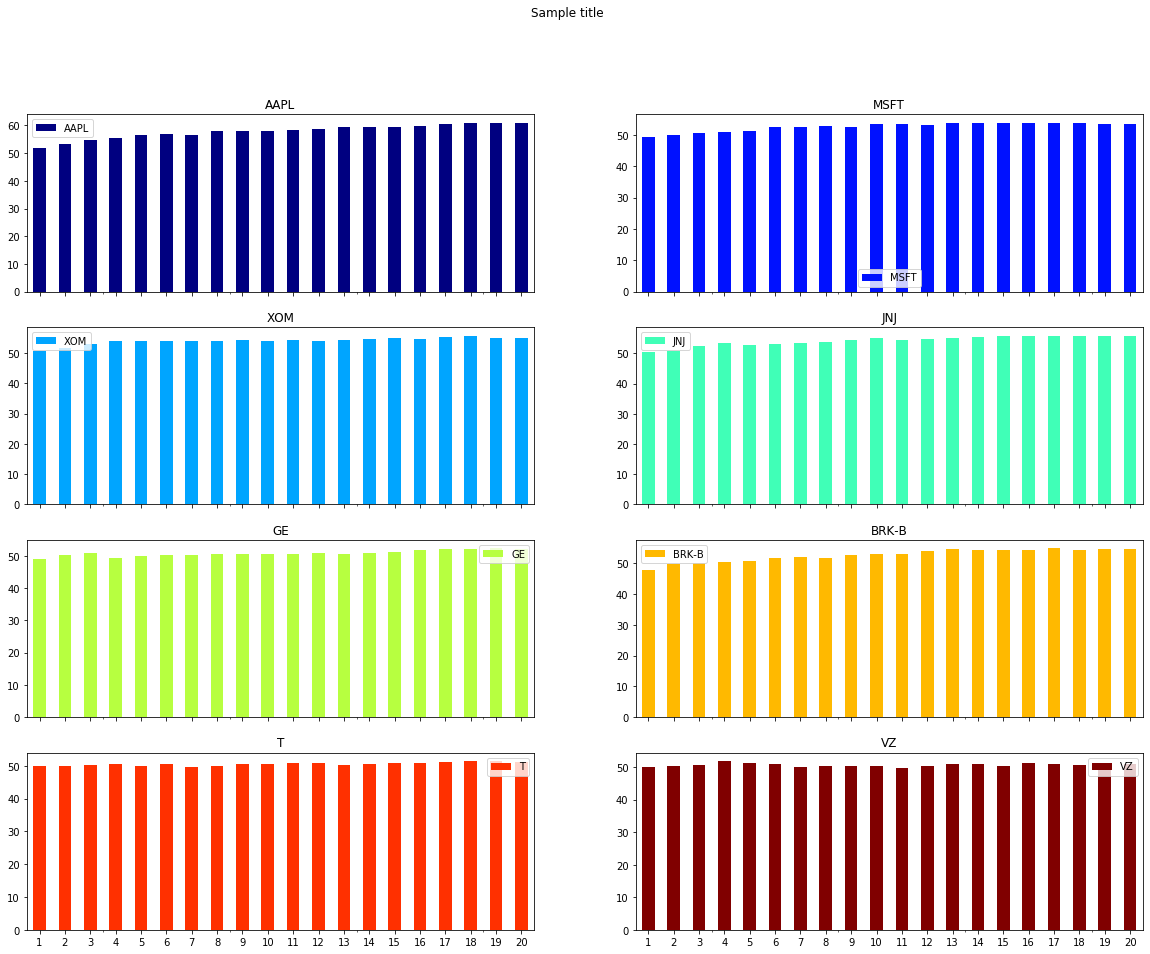

In [14]:
axes = table.plot(kind='bar',rot=0,lw=2,colormap='jet',figsize=(20,15),
             title='Sample title', subplots=True, layout=(4,2))

# Results

In [15]:
def avg_score(x_train, y_train,x_test,y_test,trees):
    accuracy = []
    f1 = []
    rf_model = RandomForestClassifier(trees)
    for i in range(5):
        rf_model.fit(x_train,y_train)
        accuracy.append(rf_model.score(x_test,y_test))
        f1.append(f1_score(y_test,rf_model.predict(x_test), pos_label='1'))
    avg_accuracy = sum(accuracy)/len(accuracy)
    avg_f1 = sum(f1)/len(f1)
    prob = rf_model.predict_proba(x_test)
    return avg_accuracy, avg_f1, prob

In [16]:
def accuracy(stocks, trees, period):
    table_accuracy = pd.DataFrame()
    table_f1 = pd.DataFrame()
    for j in stocks:
        accuracy_values = []
        f1_values = []
        for i in range(1,period+1):
            stocks_indicators = get_indicators(stocks, i)
            train, test = train_test_split(stocks_indicators[j])
            accuracy, f1, prob = avg_score(train.iloc[:,:-1],train.iloc[:,-1],test.iloc[:,:-1],test.iloc[:,-1],trees)
            accuracy_values.append(accuracy)
            f1_values.append(f1)
        table_accuracy = pd.concat([table_accuracy, pd.DataFrame({j : accuracy_values})], axis=1)
        table_f1 = pd.concat([table_f1, pd.DataFrame({j : f1_values})], axis=1)
    table_accuracy.index = range(1,period+1)
    table_f1.index = range(1,period+1)
    return table_accuracy, table_f1, prob

In [17]:
accuracy_table, f1_table, prob = accuracy(stocks, 300, 20)

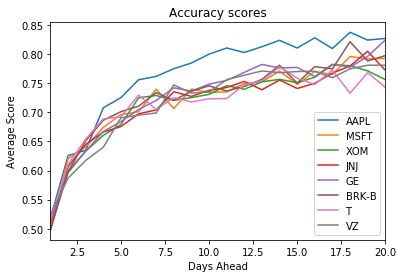

In [18]:
accuracy_table.plot()
plt.title('Accuracy scores')
plt.xlabel('Days Ahead')
plt.ylabel('Average Score')
plt.show()

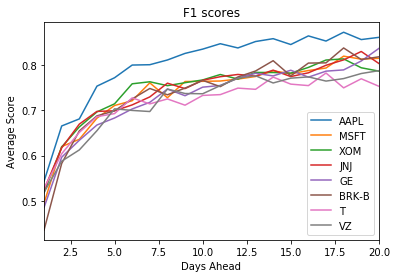

In [37]:
f1_table.plot()
plt.title('F1 scores')
plt.xlabel('Days Ahead')
plt.ylabel('Average Score')
plt.show()

In [20]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [21]:
accuracy_table.style.apply(highlight_max, axis=0)

,AAPL,MSFT,XOM,JNJ,GE,BRK-B,T,VZ
1,0.517944,0.501869,0.513458,0.497944,0.511215,0.498131,0.517196,0.523925
2,0.625607,0.620374,0.596262,0.606542,0.599813,0.597944,0.610093,0.586916
3,0.634766,0.640748,0.633271,0.64486,0.633084,0.650841,0.653832,0.617383
4,0.707664,0.674019,0.660374,0.666168,0.666916,0.686355,0.688785,0.64
5,0.725234,0.696262,0.678879,0.675514,0.684112,0.701121,0.69215,0.690467
6,0.755888,0.700935,0.72486,0.697383,0.70486,0.710467,0.729533,0.69514
7,0.761682,0.739626,0.728972,0.704112,0.720374,0.733832,0.70486,0.698879
8,0.774953,0.706542,0.720561,0.735327,0.742056,0.720561,0.725607,0.747103
9,0.784673,0.74,0.725234,0.72729,0.736449,0.736262,0.717757,0.733084
10,0.8,0.734206,0.730841,0.737757,0.748411,0.745421,0.723178,0.734766


In [22]:
f1_table.style.apply(highlight_max, axis=0)

,AAPL,MSFT,XOM,JNJ,GE,BRK-B,T,VZ
1,0.543446,0.494772,0.518189,0.524761,0.485324,0.435532,0.527691,0.518811
2,0.665542,0.619981,0.619023,0.617056,0.59644,0.582576,0.604021,0.587628
3,0.68114,0.635991,0.663457,0.669596,0.633835,0.654574,0.651342,0.612514
4,0.753614,0.682789,0.696604,0.697772,0.667632,0.687856,0.686135,0.655073
5,0.772229,0.710792,0.714514,0.699036,0.683162,0.699025,0.692891,0.703434
6,0.800305,0.721358,0.758846,0.712153,0.703149,0.725385,0.727635,0.699907
7,0.801058,0.760938,0.763294,0.729804,0.717832,0.748486,0.714386,0.697465
8,0.811527,0.727996,0.754704,0.760242,0.747171,0.734499,0.725293,0.74725
9,0.826088,0.763872,0.76128,0.748224,0.732442,0.749343,0.711501,0.737331
10,0.835543,0.76433,0.767355,0.76659,0.751376,0.766366,0.733116,0.73678


As seen from the two and tables (accuracy and F1) figures above, we get poor results for small number of days ahead (from 1 to 4) and greater results as the number of days ahead increases afterworlds. For almost all the stocks for both scores, the highest scores are in the range of 17 to 20-days ahead.

# Conclusions

Results were satisfactory. The model showed an increasing accuracy and F1 over time, with lower values in the initial days (1-4) and higher values between days 17 and 20, with accuracy scores between 78% and 84% and F1 scores between 78% and 87%. Perhaps, the model might produce better results if we insert external variables (i.e. macro economics).    